In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,transpile, Aer
from qiskit_aer import AerSimulator
from qiskit.quantum_info import state_fidelity,DensityMatrix,Statevector,partial_trace
from qiskit.providers.fake_provider import FakeVigo
from qiskit.visualization import visualize_transition,plot_bloch_multivector
from qiskit.result import marginal_counts
from qiskit.visualization import plot_distribution,plot_bloch_vector,plot_state_city,array_to_latex,plot_gate_map
from qiskit_experiments.library import StateTomography
from qiskit_experiments.library.tomography import TomographyExperiment
import numpy as np
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

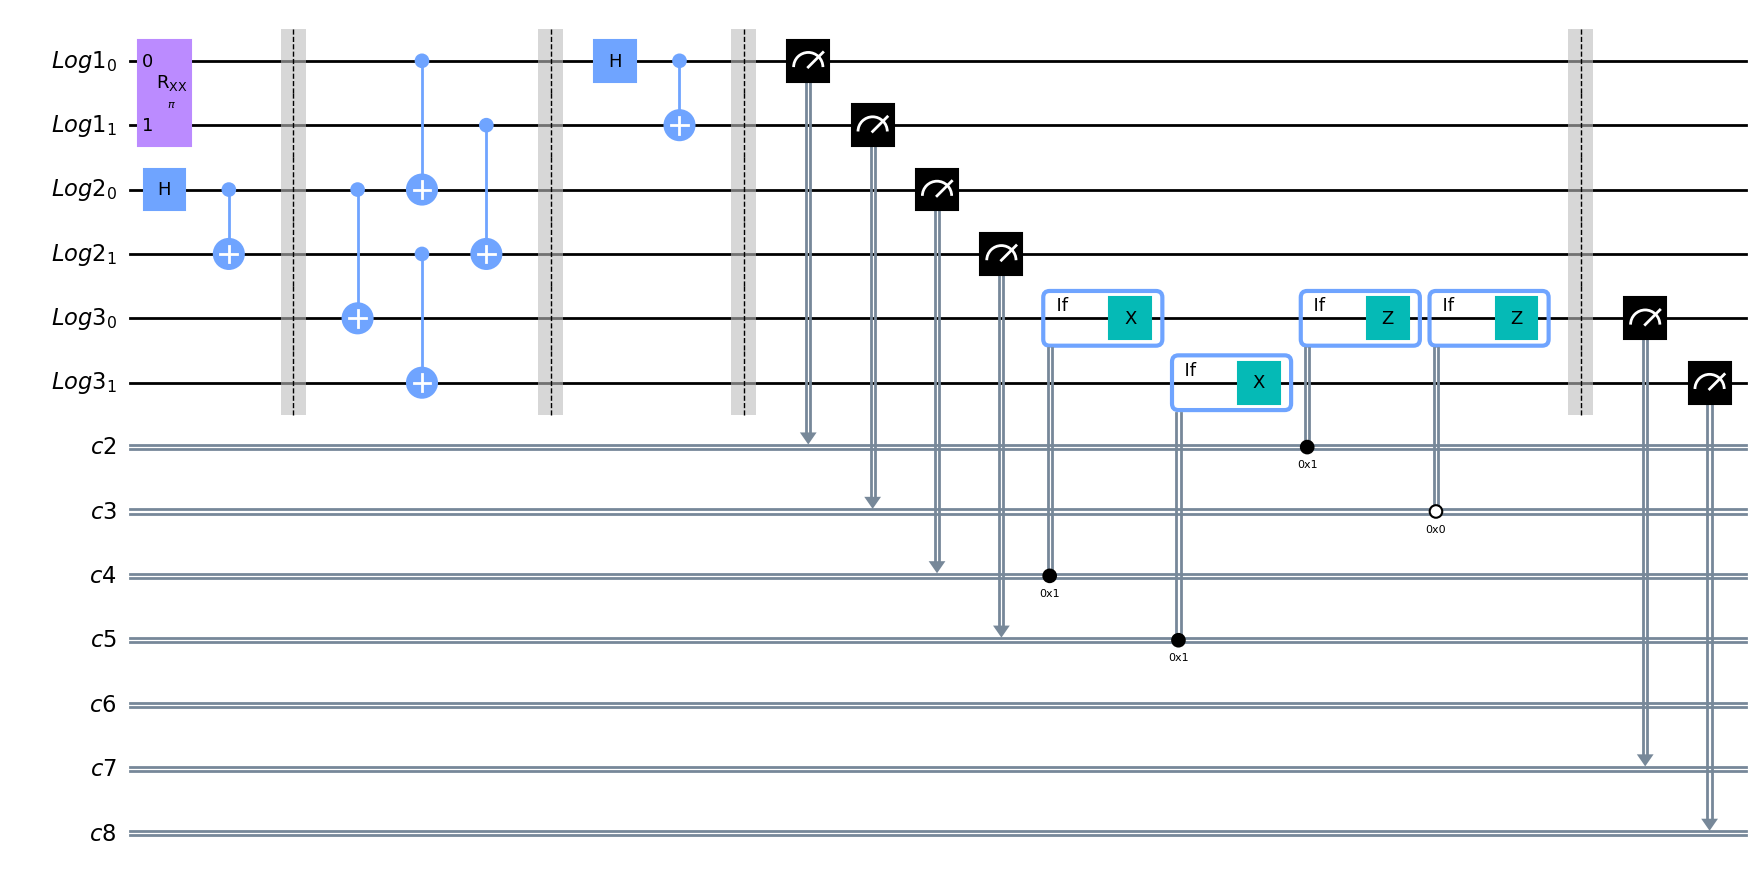

In [2]:
qr1 = QuantumRegister(2,"Log1")
qr2 = QuantumRegister(2,"Log2")
qr3 = QuantumRegister(2,"Log3")
fa_2 = ClassicalRegister(1)
fa_3 = ClassicalRegister(1)
a_2 = ClassicalRegister(1)
a_3 = ClassicalRegister(1)
a_4 = ClassicalRegister(1)
a_5 = ClassicalRegister(1)
a_6 = ClassicalRegister(1)
a_7 = ClassicalRegister(1)
a_8 = ClassicalRegister(1)
qc = QuantumCircuit(qr1,qr2,qr3,a_2,a_3,a_4,a_5,a_6,a_7,a_8)
#スタビライザZZ1
#スタビライザZZ2
#スタビライザZZ3
#ロジカルオペレーター
qc.rxx(np.pi,0,1)
#ロジカルH
qc.h(2)
qc.cx(2,3)
qc.barrier()
#ロジカルCX
qc.cx(2,4)
qc.cx(3,5)
#アリス＆チャーリー間操作
qc.cx(0,2)
qc.cx(1,3)
qc.barrier()
qc.h(0)
qc.cx(0,1)
qc.barrier()
qc.measure(0,a_2)
qc.measure(1,a_3)
qc.measure(2,a_4)
qc.measure(3,a_5)
#ポストセレクション（フィードフォワード操作）
with qc.if_test((a_4, 1)):
    qc.x(4)
with qc.if_test((a_5, 1)):
    qc.x(5)
with qc.if_test((a_2, 1)):
    qc.z(4)
with qc.if_test((a_3, 0)):
    qc.z(4)
qc.barrier()
qc.measure(4,a_7)
qc.measure(5,a_8)
qc.draw("mpl",filename="Ltelepo")

In [4]:
real_backend = provider.get_backend('ibmq_mumbai')
qc_compiled = transpile(qc, real_backend,initial_layout=[10,12,13,14,11,16],optimization_level=3)


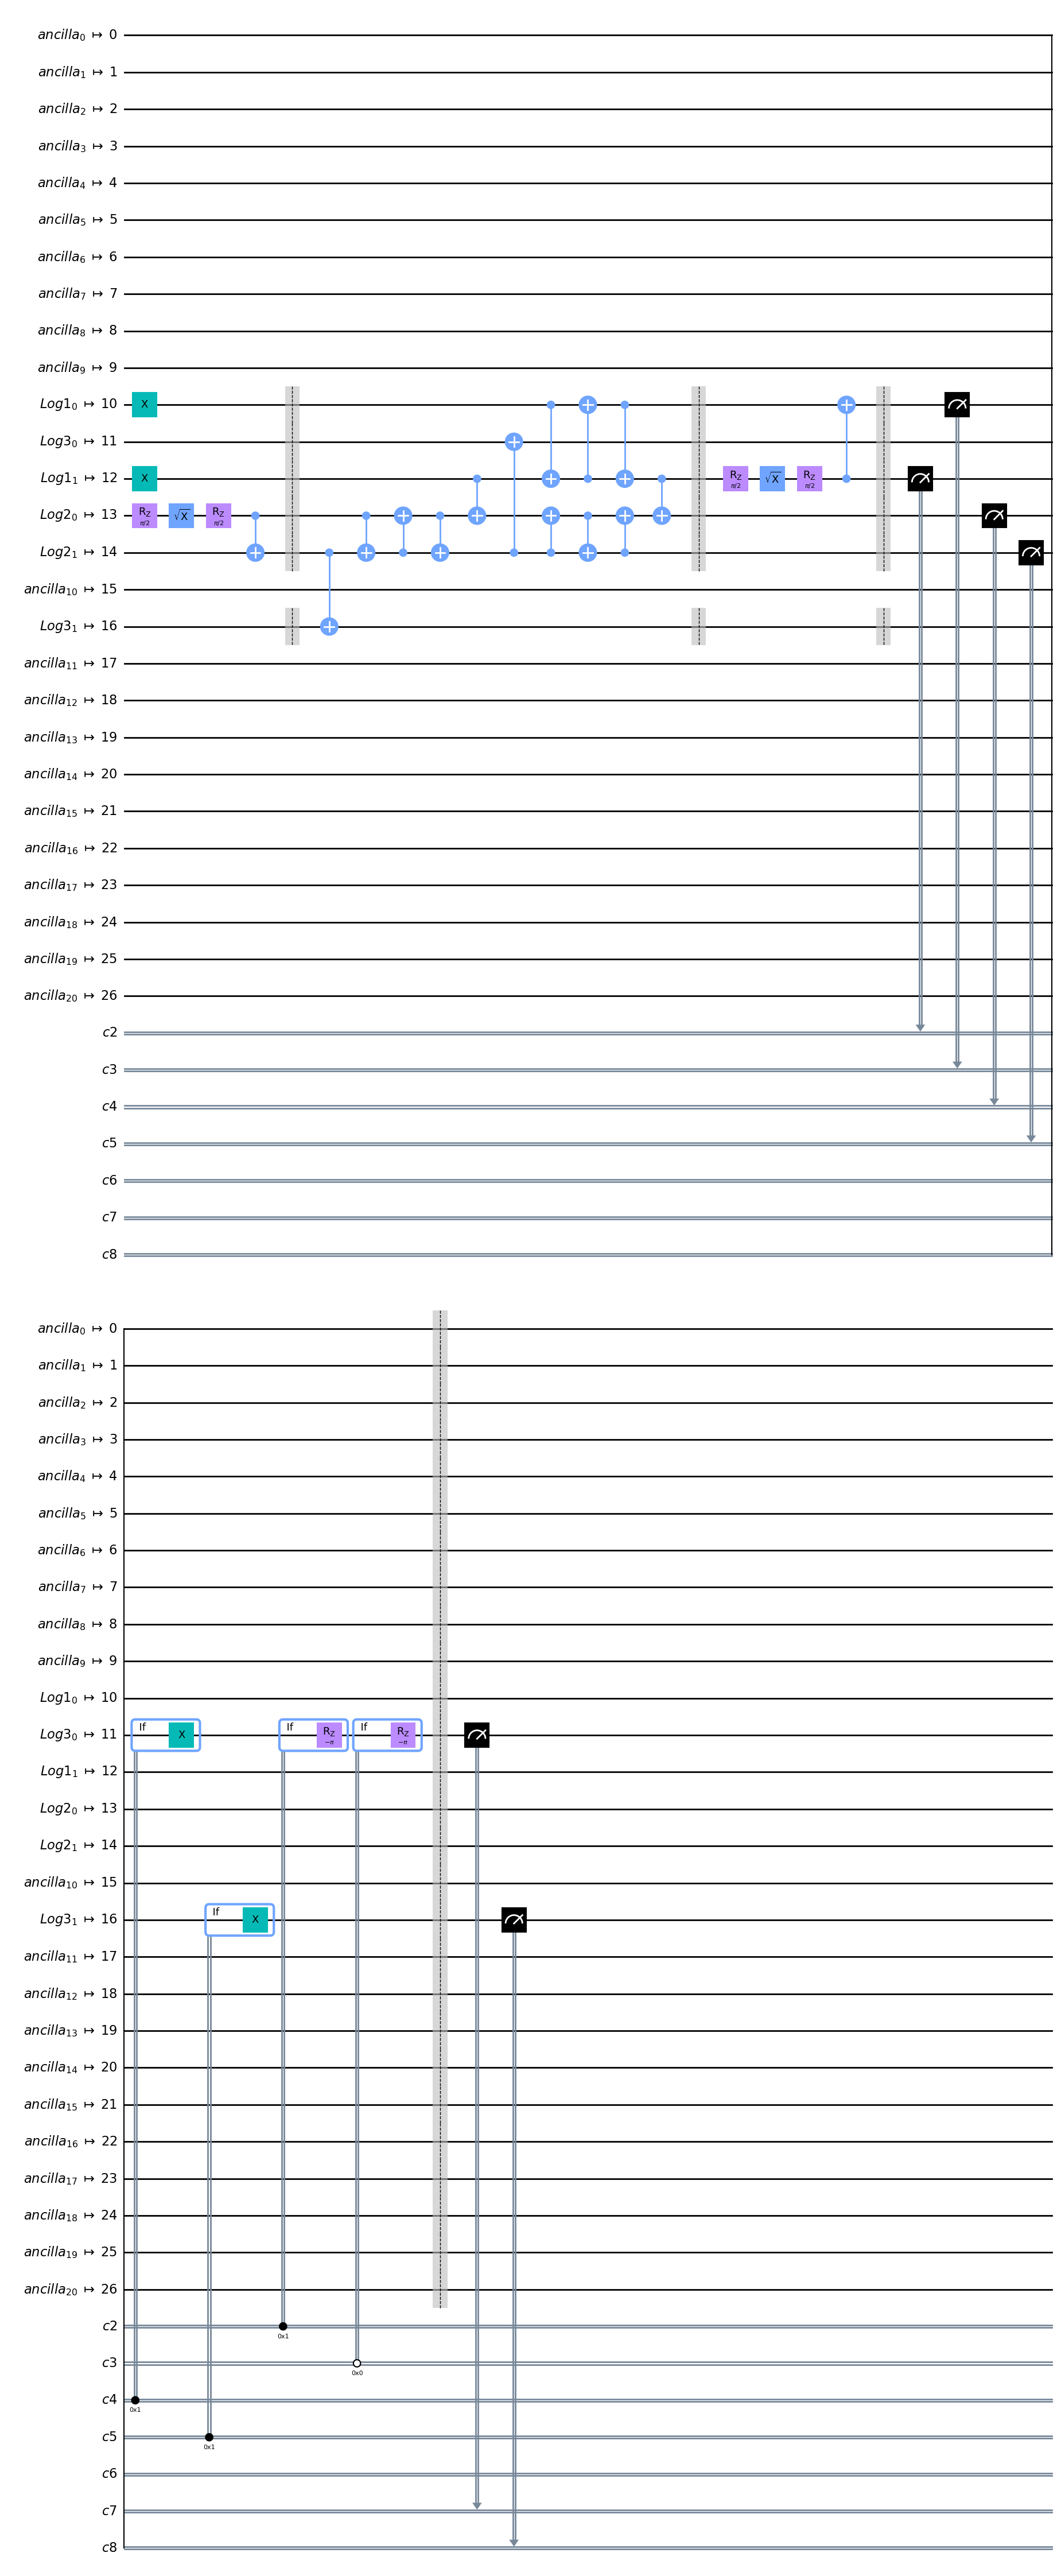

In [20]:
qc_compiled.draw("mpl",filename="Ltelepo_compiled")

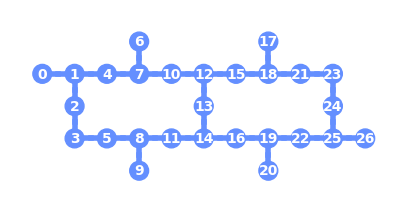

In [5]:
plot_gate_map(real_backend, plot_directed=True,filename="plot_coupling_map",)

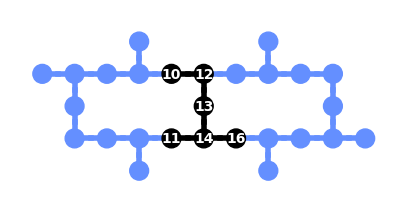

In [19]:

 
plot_circuit_layout(qc_compiled, real_backend,view='physical')

In [8]:
job = real_backend.run(qc_compiled, shots=8000, dynamic=True)

In [9]:
# ジョブの実行状態を確認
from qiskit.tools.monitor import job_monitor
print(f"Job ID: {job.job_id()}")
job_monitor(job)

Job ID: cqavcf1c0xhg008vve6g
Job Status: job has successfully run


{'1 1 0 0 0 0 1': 243, '1 1 0 1 1 0 1': 255, '1 1 0 0 0 1 0': 256, '1 1 0 1 1 1 0': 270}


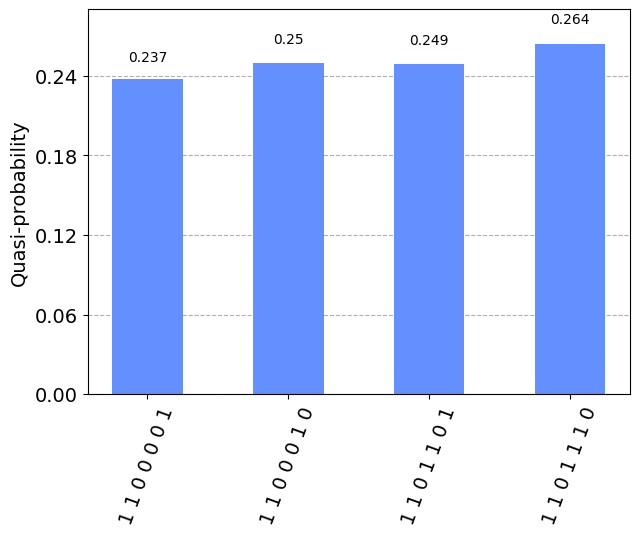

In [10]:
# QASMシミュレーターで実験
backend = Aer.get_backend('qasm_simulator')
job_sim = backend.run(qc)
result_sim = job_sim.result()
#  測定された回数を表示
counts = result_sim.get_counts()
print(counts)

plot_distribution(counts)

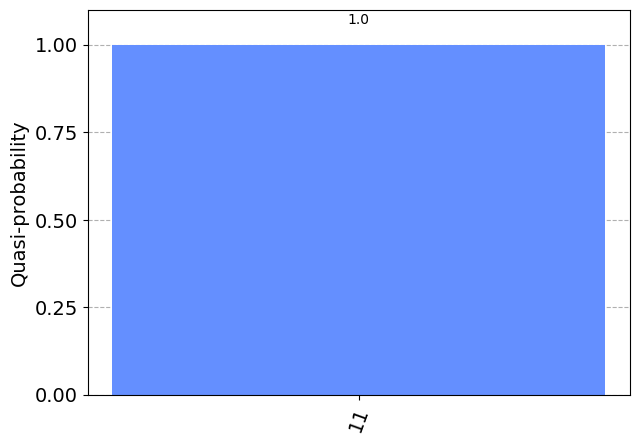

In [11]:
bobs_qubit = [5,6]
bobs_counts = marginal_counts(counts, bobs_qubit)
plot_distribution(bobs_counts)

In [12]:
aer_sim = AerSimulator()
vigo = FakeVigo()

In [13]:
qc.save_density_matrix()
perfect_result=aer_sim.run(qc).result().data()['density_matrix']
sim_result = vigo.run(qc).result().data()['density_matrix']

In [14]:
aa = partial_trace(perfect_result,[0,1,2,3])
a = partial_trace(sim_result,[0,1,2,3])
state_fidelity(aa,a)

0.9238281250000001

In [15]:
real_result = job.result()

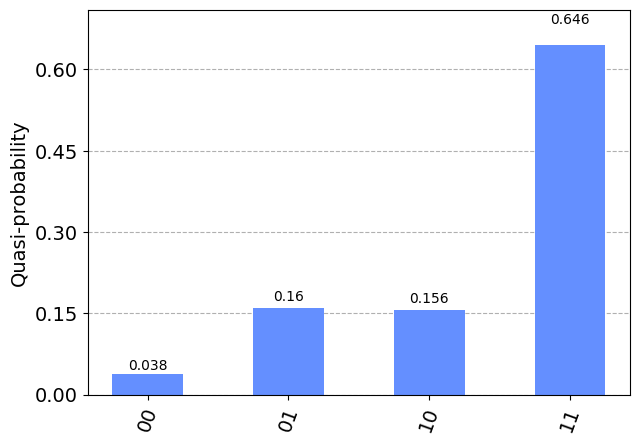

In [18]:
#ディテクション無し
from qiskit.result import marginal_counts
bobs_qubit = [5,6]
real_counts = real_result.get_counts(qc)
bobs_counts = marginal_counts(real_counts, bobs_qubit)
plot_distribution(bobs_counts)